# Импорты

In [51]:
from typing import Callable
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from src.kalman_filter import KalmanFilter, KalmanModel

# Модель грузика на пружине

In [52]:
class SpringWeightModel(KalmanModel):
    n = 0.1
    nx = 2
    nz = 1
    nu = 1
    F = np.array([[0, 1], [-1, 2 - n**2 * (1 / 3) ** 2]])
    G = np.array([[0], [n**2]])
    H = np.array([[1, 0]])
    w = np.array([[0]])
    v = np.array([[5]])

    def __init__(self, size: int, f: Callable):
        F = self.F
        G = self.G
        H = self.H
        w = self.w
        v = self.v

        N = int(size / self.n)
        abscissa = np.linspace(0, size, N)
        u = np.array([[[f(x)]] for x in abscissa])

        x = np.zeros((N, self.nx, 1))

        z = np.empty((N, self.nz, 1))
        z_clean = np.empty((N, self.nz, 1))
        for i in range(1, N):
            x[i] = F @ x[i - 1] + G @ u[i - 1] + w
            z_clean[i] = H @ x[i]
            z[i] = H @ x[i] + np.random.normal(0, v)

        self.x = x
        self.z = z
        self.u = u
        self.abscissa = abscissa
        self.z_clean = z_clean

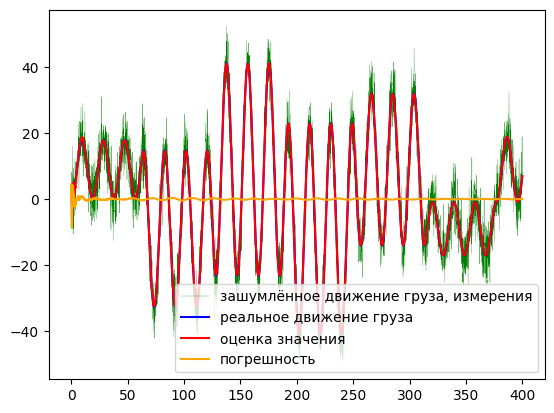

In [53]:
spring_weight_model = SpringWeightModel(400, lambda x: np.sign(np.sin(0.05 * x)))
prediction = KalmanFilter.filter(
    spring_weight_model, np.array([[0], [0]]), np.eye(spring_weight_model.nx) * 30
)

prediction = prediction.reshape((len(spring_weight_model.abscissa)))
z_clean = spring_weight_model.z_clean.reshape((len(spring_weight_model.abscissa)))

# plt.plot(
#     spring_weight_model.abscissa,
#     spring_weight_model.u.reshape((len(spring_weight_model.abscissa))),
#     color="red",
#     label="внешняя сила, действующая на груз",
# )
plt.plot(
    spring_weight_model.abscissa,
    spring_weight_model.z.reshape((len(spring_weight_model.abscissa))),
    color="green",
    label="зашумлённое движение груза, измерения",
    linewidth=0.2,
)
plt.plot(
    spring_weight_model.abscissa,
    z_clean,
    color="blue",
    label="реальное движение груза",
)
plt.plot(
    spring_weight_model.abscissa, prediction, color="red", label="оценка значения"
)
plt.plot(
    spring_weight_model.abscissa,
    prediction - z_clean,
    color="orange",
    label="погрешность",
)
plt.legend()
plt.show()

# Модель истребителя F-16

In [54]:
class F16Model(KalmanModel):
    n = 0.005
    nx = 2
    nz = 2
    nu = 1
    F = np.array([[-0.6, 0.95], [-4.3, -1.2]])
    G = np.array([[-0.115], [-5.157]])
    H = np.array([[1, 0], [0, 1]])
    w = np.array([[0], [0]])
    v = np.array([[1], [1]])

    def __init__(self, size: int, f: Callable):
        self.F = np.eye(self.nx) + self.n * self.F
        self.G = self.n * self.G

        F = self.F
        G = self.G
        H = self.H
        w = self.w
        v = self.v
        h = self.n

        N = int(size / self.n)
        abscissa = np.linspace(0, size, N)
        u = np.array([[[f(x)]] for x in abscissa])

        x = np.zeros((N, self.nx, 1))

        z = np.empty((N, self.nz, 1))
        z_clean = np.empty((N, self.nz, 1))
        for i in range(1, N):
            x[i] = F @ x[i - 1] + G @ u[i - 1] + np.random.normal(0, w)
            z_clean[i] = H @ x[i]
            z[i] = H @ x[i] + np.random.normal(0, v)

        self.x = x
        self.z = z
        self.u = u
        self.abscissa = abscissa
        self.z_clean = z_clean

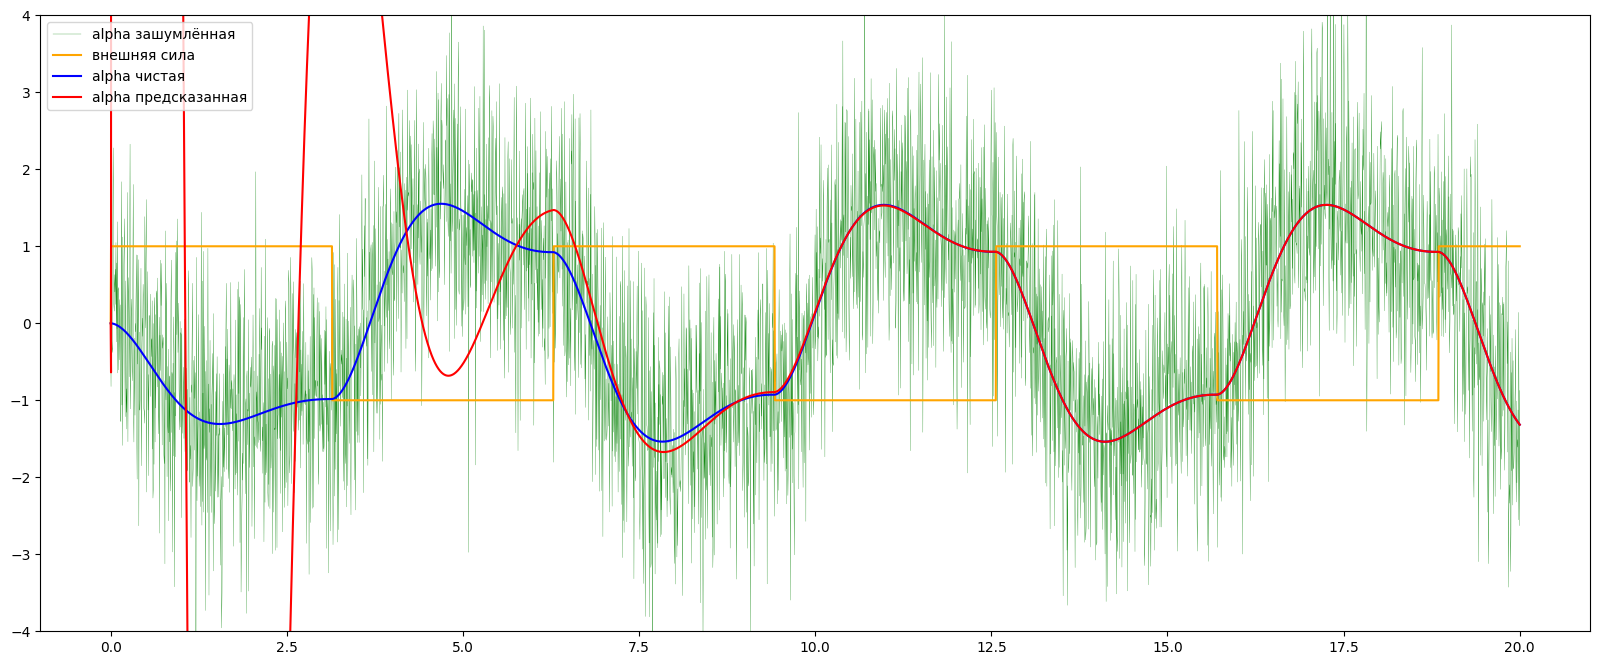

In [55]:
# %matplotlib osx

# f16_model = F16Model(10, lambda x: 0 if x < 2 or x > 4 else 2 if x < 3 else -2)
f16_model = F16Model(20, lambda x: np.sign(np.sin(x)))
prediction = KalmanFilter.filter(f16_model, np.array([[0], [0]]), np.eye(f16_model.nx))

N = len(f16_model.abscissa)
z_clean = f16_model.z_clean.reshape((N, 2))
z = f16_model.z.reshape((N, 2))
prediction = prediction.reshape((N, 2))

alpha = z[:, 0]
alpha_clean = z_clean[:, 0]
q_clean = z_clean[:, 1]
predict_alpha = prediction[:,0]

plt.figure(figsize=(20, 8))
plt.plot(
    f16_model.abscissa, alpha, color="green", label="alpha зашумлённая", linewidth=0.2
)
plt.plot(
    f16_model.abscissa, f16_model.u.reshape((N)), color="orange", label="внешняя сила"
)
plt.plot(f16_model.abscissa, alpha_clean, color="blue", label="alpha чистая")
plt.plot(f16_model.abscissa, predict_alpha, color="red", label="alpha предсказанная")
# plt.plot(f16_model.abscissa, q_clean, color="green", label="q чистая")
plt.ylim(-4, 4)
plt.legend()
plt.show()